In [48]:
# Analysis of Insurance company data

In [35]:
# import libraries
import pandas as pd
import numpy as np

# visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# sklearn
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split, RepeatedKFold, RandomizedSearchCV, RepeatedKFold, KFold, StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, mean_squared_error 
from sklearn.metrics import recall_score, r2_score,roc_auc_score,roc_curve,precision_score
from sklearn.svm import SVC
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier

from sklearn.externals import joblib
from scipy.stats import linregress
from xgboost.sklearn import XGBClassifier

import itertools

from scipy.stats import randint, uniform

In [3]:
df = pd.read_csv('insurance.csv', index_col=2)
df.head()

,TARGET,loyalty,age,city,LOR,prod_A,type_A,type_B,prod_B,turnover_A,turnover_B,contract,age_P,lor_M
ID,,,,,,,,,,,,,,
77,Y,99,66,2,0,0,0,0,0,333.561114,264.721010,2,66,3
159,Y,1,45,2,3,1,3,3,1,394.735699,284.904978,2,45,39
220,Y,1,42,2,2,1,3,6,1,342.180990,1175.589721,2,42,27
303,Y,99,31,2,0,0,0,0,0,453.757916,242.341754,2,31,3
306,Y,99,62,2,0,0,0,0,0,384.577469,287.008370,2,62,3


In [4]:
df.describe()

,loyalty,age,city,LOR,prod_A,type_A,type_B,prod_B,turnover_A,turnover_B,contract,age_P,lor_M
count,14016.000000,14016.000000,14016.000000,14016.000000,14016.000000,14016.000000,14016.000000,14016.000000,14016.000000,14016.000000,14016.0,14016.000000,14016.000000
mean,50.381778,35.882920,-710.950128,0.926299,0.533818,1.607877,1.918878,0.599458,379.161320,328.628207,2.0,35.882920,14.115582
std,48.471790,12.974634,26702.329184,0.965212,0.498873,1.508991,1.686038,0.490026,92.612207,475.616525,0.0,12.974634,11.582550
min,0.000000,5.000000,-999999.000000,0.000000,0.000000,0.000000,0.000000,0.000000,300.095909,191.962852,2.0,5.000000,3.000000
25%,2.000000,25.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.919412,219.406925,2.0,25.000000,3.000000
50%,3.000000,33.000000,2.000000,1.000000,1.000000,3.000000,3.000000,1.000000,367.891493,237.656757,2.0,33.000000,15.000000
75%,99.000000,43.000000,2.000000,1.000000,1.000000,3.000000,3.000000,1.000000,399.744923,264.131538,2.0,43.000000,15.000000
max,99.000000,102.000000,235.000000,6.000000,1.000000,6.000000,9.000000,1.000000,5568.784139,12249.084770,2.0,102.000000,75.000000


In [5]:
df[['prod_A','type_A','prod_B','type_B']].corr()

,prod_A,type_A,prod_B,type_B
prod_A,1.000000,0.995778,0.874710,0.816231
type_A,0.995778,1.000000,0.871017,0.820344
prod_B,0.874710,0.871017,1.000000,0.930338
type_B,0.816231,0.820344,0.930338,1.000000


In [6]:
# map values to boolean variables
df.replace({'TARGET': {'Y': 1, 'N': 0}}, inplace=True)

In [7]:
df.TARGET.value_counts()

0    8000
1    6016
Name: TARGET, dtype: int64

In [8]:
# nearly half of the values are missing for loyalty
sum(df['loyalty']==99)/len(df['loyalty']) 

0.49843036529680368

In [9]:
# reorder columns
df = df[['TARGET','loyalty','age','age_P','city',
         'LOR','lor_M','prod_A','type_A','turnover_A',
         'prod_B','type_B','turnover_B','contract']]

In [10]:
# loyalty

# replace loyalty values=99 with the median value
df['loyalty'].replace(to_replace=99,value=df['loyalty'].median(),inplace=True)

# replace city values=-999999 with the median value
df.replace(np.nan,df.city.median(),inplace=True)

In [11]:
# contract

print(df.contract.value_counts())

# drop the variable 'contract' because it is a constant, and will provide no discriminitive power when model building
df.drop(labels='contract',axis=1,inplace=True)

2    14016
Name: contract, dtype: int64


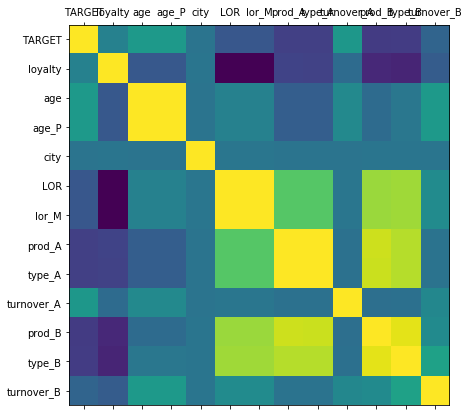

In [12]:
def plot_corr(df,size=10):
    '''Function plots a graphical correlation matrix for each pair of columns in the dataframe.

    Input:
        df: pandas DataFrame
        size: vertical and horizontal size of the plot'''

    corr = df.corr()
    fig, ax = plt.subplots(figsize=(size, size))
    ax.matshow(corr)
    plt.xticks(range(len(corr.columns)), corr.columns);
    plt.yticks(range(len(corr.columns)), corr.columns);

plot_corr(df,size=7)

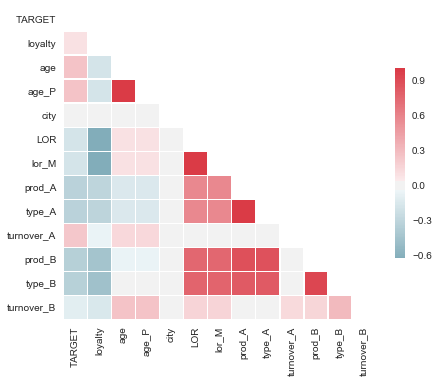

In [13]:
# calculate the correlation matrix
corr = df.corr()

sns.set(style="white")
sns.color_palette("Blues_d")

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(7, 7))


# plot the heatmap
h = sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,
           center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5},cmap=cmap, mask=mask)
plt.show()
#h.get_figure().savefig('corr_heat_map.png')

In [14]:
df.isnull().sum()

TARGET        0
loyalty       0
age           0
age_P         0
city          0
LOR           0
lor_M         0
prod_A        0
type_A        0
turnover_A    0
prod_B        0
type_B        0
turnover_B    0
dtype: int64

In [15]:
df.TARGET = df.TARGET.astype('category')
df.prod_A = df.prod_A.astype('category')
df.prod_B = df.prod_B.astype('category')

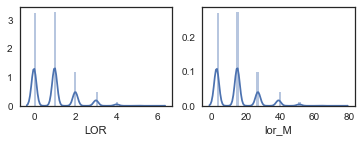

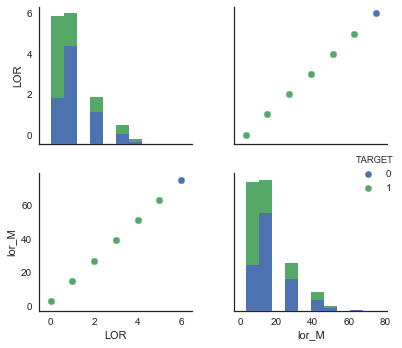

In [16]:
# closer look at LOR and lor_M
# distributions are nearly identical, are perfectly correlated

plt.subplot(2,2,1)
#plt.text(60, 0.135, 'LOR and lor_M distributions', size = 15)
sns.distplot(df['LOR'])
plt.subplot(2,2,2)
sns.distplot(df['lor_M'])

p1 = sns.pairplot(data=df,vars=['LOR','lor_M'],hue='TARGET')
#plt.text(-40, 120, 'Pair plot', size=15)
plt.tight_layout()
plt.show()
p1.savefig("pairplot_LOR_lor_M.png")

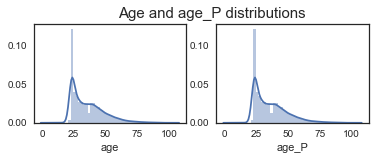

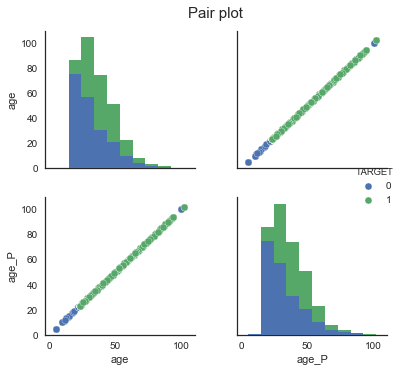

In [17]:
# closer look at age and age_P
# distributions are nearly identical, are perfectly correlated

plt.subplot(2,2,1)
plt.text(60, 0.135, 'Age and age_P distributions', size = 15)
sns.distplot(df['age'])
plt.subplot(2,2,2)
sns.distplot(df['age_P'])

p1 = sns.pairplot(data=df,vars=['age','age_P'],hue='TARGET')
plt.text(-40, 120, 'Pair plot', size=15)
plt.tight_layout()
plt.show()
p1.savefig("pairplot_age_age_P.png")

In [18]:
# drop age of partner as it is nearly identical in values
linregress(df.age, df.age_P), linregress(df.LOR, df.lor_M)

(LinregressResult(slope=0.99999999999999978, intercept=7.1054273576010019e-15, rvalue=1.0, pvalue=0.0, stderr=0.0),
 LinregressResult(slope=11.999999999999986, intercept=3.0000000000000124, rvalue=0.99999999999999922, pvalue=0.0, stderr=3.9964034223646586e-09))

In [19]:
# drop age_P and LOR variable
df.drop(labels=['age_P','LOR'],axis=1,inplace=True)

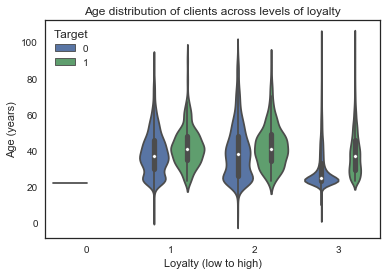

In [20]:
# 
p3 = sns.violinplot(x='loyalty', y='age', data=df, hue='TARGET', dodge=True)
plt.legend(loc='upper left', title='Target')
plt.title('Age distribution of clients across levels of loyalty')
plt.xlabel('Loyalty (low to high)')
plt.ylabel('Age (years)')
plt.show()

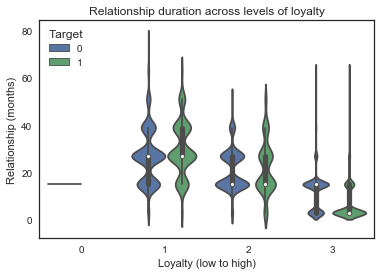

In [21]:
p4 = sns.violinplot(x='loyalty', y='lor_M', data=df, hue='TARGET', dodge=True)
plt.legend(loc='upper left', title='Target')
plt.title('Relationship duration across levels of loyalty')
plt.xlabel('Loyalty (low to high)')
plt.ylabel('Relationship (months)')
plt.show()

In [67]:
# Model building

In [22]:
# separate df into X, y 
X = df.drop('TARGET', axis=1)
y = df.TARGET
# create training and testing vars
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=2343, stratify=y)
print('Training set has', X_train.shape[1], ' predictors and ', X_train.shape[0], ' rows.')
print('holdout set has', X_test.shape[1], ' predictors and ', X_test.shape[0], ' rows.')

Training set has 10  predictors and  11212  rows.
holdout set has 10  predictors and  2804  rows.


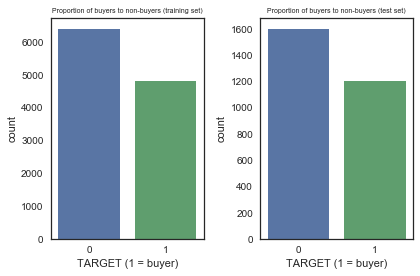

In [19]:
# check proportion of 1s on training and test set
plt.subplot(1,2,1)
sns.countplot(x=y_train)
plt.title('Proportion of buyers to non-buyers (training set)', size=7)
plt.xlabel('TARGET (1 = buyer)')
plt.subplot(1,2,2)
sns.countplot(x=y_test)
plt.title('Proportion of buyers to non-buyers (test set)', size=7)
plt.xlabel('TARGET (1 = buyer)')
plt.tight_layout()
plt.show()

Optimal number of features : 9


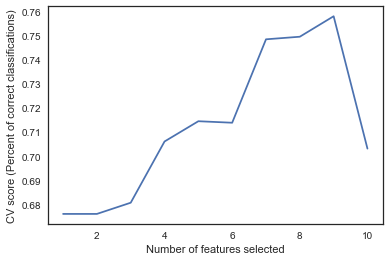

In [70]:
# FEATURE SELECTION

from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV

# Create the RFE object and compute a cross-validated score.
lrCV = LogisticRegressionCV()
rfC = RandomForestClassifier()

# The "accuracy" scoring is proportional to the number of correct
# classifications
rfecv = RFECV(estimator=lrCV, step=1, cv=StratifiedKFold(10),
              scoring='accuracy')
rfecv.fit(X_train, y_train)



print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
p=plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("CV score (Percent of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()
#p.savefig('nb_features_selected.png')

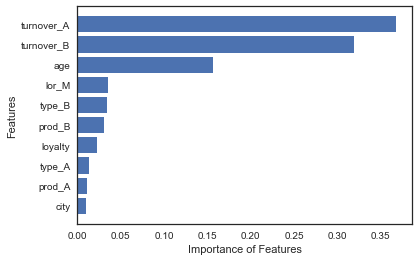

In [22]:
# FEATURE IMPORTANCES

# to get an idea of which are the most important predictors let's rerun the optimal model and try to extract
# feature_importances_

from sklearn.ensemble import RandomForestClassifier

clf_fi = RandomForestClassifier(n_estimators=100, random_state=54645, class_weight="balanced", n_jobs=-1,
                               max_depth=None, max_features='auto')

clf_fi.fit(X_train, y_train)
pred_fi = clf_fi.predict(X_test)

imp = clf_fi.feature_importances_
names = X_train.columns
imp, names = zip(*sorted(zip(imp, names)))

p=plt.figure()
plt.barh(range(len(names)), imp, align = 'center')
plt.yticks(range(len(names)), names)

plt.xlabel('Importance of Features')
plt.ylabel('Features')
#plt.title('Importance of each feature')
plt.show()
p.savefig('feature_importance.png')

In [75]:
# LogisticRegression 

# Declare data preprocessing steps
pipeline = make_pipeline(preprocessing.StandardScaler(), LogisticRegression())
 
# Declare hyperparameters to tune
hyperparameters = {'logisticregression__C': [5, 10, 20]}

# Tune model using cross-validation pipeline
folds = 10
clf = GridSearchCV(pipeline, hyperparameters, cv=folds)
 
clf.fit(X_train, y_train)
 
# Refit on the entire training set
# No additional code needed if clf.refit == True (default is True)
 
# Evaluate model pipeline on test data
pred = clf.predict(X_test)
pred_bin = preprocessing.binarize(pred.reshape(-1,1), threshold=0.5)
print(r2_score(y_test, pred))
print(mean_squared_error(y_test, pred))

joblib.dump(clf, 'log_reg_regressor.pkl')

0.0495161960133
0.232881597718


['log_reg_regressor.pkl']

In [76]:
# RANDOM FOREST Pipeline
# with standardization, CV, 

# Declare data preprocessing steps
pipeline = make_pipeline(preprocessing.StandardScaler(), 
                         RandomForestClassifier(n_estimators=100, random_state=54645, class_weight="balanced", n_jobs=-1))
 
# Declare hyperparameters to tune
hyperparameters = { 'randomforestclassifier__max_features' : ['auto', 'sqrt', 'log2'],
                  'randomforestclassifier__max_depth': [None, 5, 3, 1]}
 
# Tune model using cross-validation pipeline
clf2 = GridSearchCV(pipeline, hyperparameters, cv=10)
 
clf2.fit(X_train, y_train)
 
# Refit on the entire training set
# No additional code needed if clf.refit == True (default is True)
 
# Evaluate model pipeline on test data
pred2 = clf2.predict(X_test)
pred_bin2 = preprocessing.binarize(pred2.reshape(-1,1), threshold=0.5)
print(r2_score(y_test, pred2))
print(mean_squared_error(y_test, pred2))

joblib.dump(clf2, 'rf_regressor.pkl')

0.78457641196
0.0527817403709


['rf_regressor.pkl']

In [54]:
# AdaBoost 

# Declare data preprocessing steps
pipeline = make_pipeline(preprocessing.StandardScaler(), 
                         AdaBoostClassifier(base_estimator=ExtraTreesClassifier(class_weight='balanced'),
                                            random_state=54645,
                                            algorithm='SAMME.R'))

# Declare hyperparameters to tune
hyperparameters = { 'adaboostclassifier__n_estimators' : [1000],
                  'adaboostclassifier__learning_rate': [1,0.1,0.001]}
 
# Tune model using cross-validation pipeline
splits = 10
folds = StratifiedKFold(n_splits=splits, random_state=8468468, shuffle=True)
clf3 = GridSearchCV(pipeline, hyperparameters, cv=folds, n_jobs=-1)
 
clf3.fit(X_train, y_train)
 
# Refit on the entire training set
# No additional code needed if clf.refit == True (default is True)
 
# Evaluate model pipeline on test data
pred3 = clf3.predict(X_test)
pred_bin3 = preprocessing.binarize(pred3.reshape(-1,1), threshold=0.5)
print(r2_score(y_test, pred3))
print(mean_squared_error(y_test, pred3))

joblib.dump(clf3, 'ada_regressor.pkl')

0.79185423588
0.0509985734665


['ada_regressor.pkl']

In [78]:
# ExtraTreesClassifier(n_estimators=10, criterion=’gini’, max_depth=None, min_samples_split=2, 
#                      min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=’auto’, 
#                      max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, 
#                     bootstrap=False, oob_score=False, n_jobs=1, random_state=None, verbose=0, 
#                     warm_start=False, class_weight=None)

# Declare data preprocessing steps
pipeline = make_pipeline(preprocessing.StandardScaler(), 
                         ExtraTreesClassifier(n_jobs=-1, random_state=54645, class_weight='balanced'))
 
# Declare hyperparameters to tune
hyperparameters = {'extratreesclassifier__n_estimators': [500, 1000],
                   'extratreesclassifier__max_depth': [None, 20],
                   'extratreesclassifier__max_features': ['auto'],
                   'extratreesclassifier__min_samples_leaf': [1]
                  }

# Tune model using cross-validation pipeline
splits = 10
folds = StratifiedKFold(n_splits=splits, random_state=8468468, shuffle=True)
clf4 = GridSearchCV(pipeline, hyperparameters, cv=folds)
 
clf4.fit(X_train, y_train)
 
# Refit on the entire training set
# No additional code needed if clf.refit == True (default is True)
 
# Evaluate model pipeline on test data
pred4 = clf4.predict(X_test)
pred_bin4 = preprocessing.binarize(pred4.reshape(-1,1), threshold=0.5)
print(r2_score(y_test, pred4))
print(mean_squared_error(y_test, pred4))

joblib.dump(clf4, 'ext_regressor.pkl')

0.799132059801
0.0492154065621


['ext_regressor.pkl']

In [79]:
# SVM

# Declare data preprocessing steps
pipeline = make_pipeline(preprocessing.StandardScaler(), SVC(probability=True))
 
# Declare hyperparameters to tune
hyperparameters = {'svc__C': [1, 10, 100], 'svc__gamma': [0.01, 0.001, 0.0001]}

# 7. Tune model using cross-validation pipeline
folds = 10
clf5 = GridSearchCV(pipeline, hyperparameters, cv=folds)
 
clf5.fit(X_train, y_train)
 
# 8. Refit on the entire training set
# No additional code needed if clf.refit == True (default is True)
 
# 9. Evaluate model pipeline on test data
pred5 = clf5.predict(X_test)
pred_bin5 = preprocessing.binarize(pred5.reshape(-1,1), threshold=0.5)
print(r2_score(y_test, pred5))
print(mean_squared_error(y_test, pred5))

joblib.dump(clf5, 'svm_regressor.pkl')

0.33189576412
0.163694721826


['svm_regressor.pkl']

In [23]:
# load models ########

clf = joblib.load('log_reg_regressor.pkl')
clf2 = joblib.load('rf_regressor.pkl')
clf3 = joblib.load('ada_regressor.pkl')
clf4 = joblib.load('ext_regressor.pkl')
clf5 = joblib.load('svm_regressor.pkl')

pred = clf.predict(X_test)
pred_bin = preprocessing.binarize(pred.reshape(-1,1), threshold=0.5)

pred2 = clf2.predict(X_test)
pred_bin2 = preprocessing.binarize(pred2.reshape(-1,1), threshold=0.5)

pred3 = clf3.predict(X_test)
pred_bin3 = preprocessing.binarize(pred3.reshape(-1,1), threshold=0.5)

pred4 = clf4.predict(X_test)
pred_bin4 = preprocessing.binarize(pred4.reshape(-1,1), threshold=0.5)

pred5 = clf5.predict(X_test)
pred_bin5 = preprocessing.binarize(pred5.reshape(-1,1), threshold=0.5)

In [58]:
from sklearn.metrics import confusion_matrix

print('Log Reg',confusion_matrix(y_test, pred_bin))
print('RF',confusion_matrix(y_test, pred_bin2))
print('AdaBoost',confusion_matrix(y_test, pred_bin3))
print('ExtraTreesClassifier',confusion_matrix(y_test, pred_bin4))
print('SVM',confusion_matrix(y_test, pred_bin5))

from sklearn.metrics import classification_report
print('Log reg',classification_report(y_test, pred_bin))
print('RF',classification_report(y_test, pred_bin2))
print('AdaBoost',classification_report(y_test, pred_bin3))
print('ExtraTreesClassifier',classification_report(y_test, pred_bin4))
print('SVM',classification_report(y_test, pred_bin5))

Log Reg [[1311  289]
 [ 364  840]]
RF [[1506   94]
 [  54 1150]]
AdaBoost [[1527   73]
 [  70 1134]]
ExtraTreesClassifier [[1526   74]
 [  64 1140]]
SVM [[1460  140]
 [ 319  885]]
Log reg              precision    recall  f1-score   support

          0       0.78      0.82      0.80      1600
          1       0.74      0.70      0.72      1204

avg / total       0.77      0.77      0.77      2804

RF              precision    recall  f1-score   support

          0       0.97      0.94      0.95      1600
          1       0.92      0.96      0.94      1204

avg / total       0.95      0.95      0.95      2804

AdaBoost              precision    recall  f1-score   support

          0       0.96      0.95      0.96      1600
          1       0.94      0.94      0.94      1204

avg / total       0.95      0.95      0.95      2804

ExtraTreesClassifier              precision    recall  f1-score   support

          0       0.96      0.95      0.96      1600
          1       0.94     

In [36]:
print('LR: ',precision_score(y_test,pred_bin))
print('RF: ',precision_score(y_test,pred_bin2))
print('AdaBoost: ',precision_score(y_test,pred_bin3))
print('ExtraTrees: ',precision_score(y_test,pred_bin4))
print('SVM: ',precision_score(y_test,pred_bin5))

print('ExtraTrees, accuracy: ',accuracy_score(y_test,pred_bin4))
print('ExtraTrees, recall: ',recall_score(y_test,pred_bin4))

LR:  0.74402125775
RF:  0.924437299035
AdaBoost:  0.93951946976
ExtraTrees:  0.939044481054
SVM:  0.863414634146
ExtraTrees, accuracy:  0.950784593438
ExtraTrees, recall:  0.946843853821


In [28]:
# make table of results
table_list = [['Algorithm', 'Precision','MSE','FP+FN','AUC'],
             ['Log Reg', '0.7440', '0.2329', '653', '0.75852'],
             ['RF', '0.9244', '0.0528', '148', '0.94820'],
             ['AdaBoost', '0.9395', '0.0510', '143', '0.94812'],
             ['ExtraTrees', '0.9390', '0.0492', '138', '0.95030'],
             ['SVM', '0.8634', '0.1637', '459', '0.82377']]

for item in table_list:
    print(item[0], ' '*(10-len(item[0])),
         item[1], ' '*(10-len(item[1])),
         item[2], ' '*(10-len(item[2])),
         item[3], ' '*(10-len(item[3])),
         item[4], ' '*(10-len(item[4])))

Algorithm   Precision   MSE         FP+FN       AUC        
Log Reg     0.7440      0.2329      653         0.75852    
RF          0.9244      0.0528      148         0.94820    
AdaBoost    0.9395      0.0510      143         0.94812    
ExtraTrees  0.9390      0.0492      138         0.95030    
SVM         0.8634      0.1637      459         0.82377    


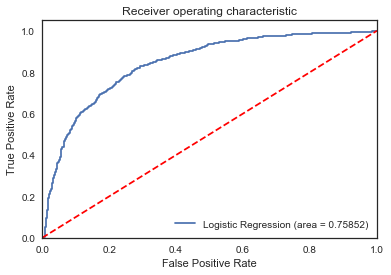

In [90]:


logit_roc_auc = roc_auc_score(y_test, clf.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:,1])

plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.5f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
#plt.savefig('Log_ROC.png')
plt.show()


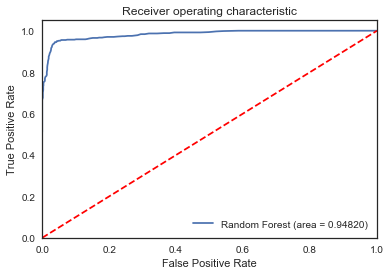

In [91]:
logit_roc_auc = roc_auc_score(y_test, clf2.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, clf2.predict_proba(X_test)[:,1])

plt.figure()
plt.plot(fpr, tpr, label='Random Forest (area = %0.5f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
#plt.savefig('RF_ROC.png')
plt.show()

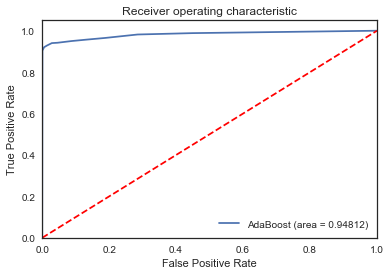

In [59]:
logit_roc_auc = roc_auc_score(y_test, clf3.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, clf3.predict_proba(X_test)[:,1])

plt.figure()
plt.plot(fpr, tpr, label='AdaBoost (area = %0.5f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
#plt.savefig('ADA_ROC.png')
plt.show()

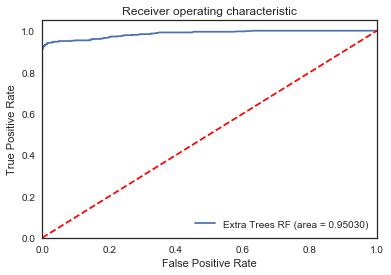

In [93]:
logit_roc_auc = roc_auc_score(y_test, clf4.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, clf4.predict_proba(X_test)[:,1])

plt.figure()
plt.plot(fpr, tpr, label='Extra Trees RF (area = %0.5f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
#plt.savefig('EXT_ROC.png')
plt.show()

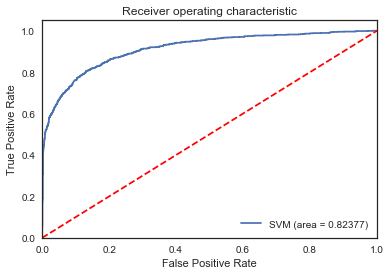

In [94]:
logit_roc_auc = roc_auc_score(y_test, clf5.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, clf5.predict_proba(X_test)[:,1])

plt.figure()
plt.plot(fpr, tpr, label='SVM (area = %0.5f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
#plt.savefig('SVM_ROC.png')
plt.show()

In [29]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix
[[1526   74]
 [  64 1140]]


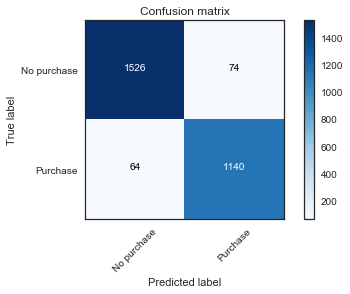

In [31]:
# Compute confusion matrix
target_names = np.array(['No purchase', 'Purchase'])
cnf_matrix = confusion_matrix(y_test, pred4)
np.set_printoptions(precision=2)

p=plt.figure()
plot1 = plot_confusion_matrix(cnf_matrix, classes=target_names, title='Confusion matrix')
plt.show()
p.savefig('confusion_matrix_ext.png')

In [ ]:
# save csv with predictions

In [37]:
all_data_pred = clf4.predict_proba(X)[:,1]

In [43]:
# create 4 categories based on the model's assignment of probability of buying the product
Profile = []
for item in all_data_pred:
    if 0 <= item < 0.25:
        Profile.append(1)
    elif 0.25 <= item < 0.50:
        Profile.append(2)
    elif 0.50 <= item < 0.75:
        Profile.append(3)    
    else: Profile.append(4)

print('Unlikely: ', Profile.count(1), '\n',
      'Probable: ', Profile.count(2), '\n',
      'Likely: ', Profile.count(3), '\n',
      'Highly likely: ', Profile.count(4))

Unlikely:  7750 
 Probable:  240 
 Likely:  83 
 Highly likely:  5943


In [44]:
Profile.count(1)+Profile.count(2)+Profile.count(3)+Profile.count(4)

14016

In [45]:
temp_df = pd.DataFrame(
    {'y_actual': y,
     'y_pred': all_data_pred,
     'profile': Profile
    })

temp_df.shape, X.shape

((14016, 3), (14016, 10))

In [46]:
# combine X_test, y_test, y_pred
df_profile = pd.concat([X, temp_df], axis=1)

In [47]:
# SAVE 
df_profile.to_csv('df_profile.csv')